# Download the Sentienl images

In [1]:
# !pip install geopandas
# !pip install planetary_computer
# !pip install odc-stac
# !pip install rioxarray
# !pip install shapely
# !pip install Basemap

In [1]:
import pandas as pd
import numpy as np

import planetary_computer as pc

import pystac_client
from pystac_client import Client

from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load, configure_rio

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import rioxarray

import rasterio
import rasterio.plot
from rasterio.mask import mask
import math
import rioxarray
from shapely.geometry import Point, box

from shapely.geometry import Point, Polygon


import numpy as np
from PIL import Image
import torch
from torchvision import transforms

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

/opt/anaconda3/envs/rishabh_space/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Function definations:

In [2]:
# Zoom level is 17
def project(lat,long):
    lat = np.radians(lat)
    long = np.radians(long)
    x = (128/np.pi)*(2**17)*(long + np.pi)
    y = (128/np.pi)*(2**17)*(np.pi - np.log(np.tan(np.pi/4 + lat/2)))
    return x,y

def inverse_project(x,y):
    F  = 128 / np.pi * 2 ** 17
    lng = (x / F) - np.pi
    lat = (2 * np.arctan(np.exp(np.pi - y/F)) - np.pi / 2)
    lng = lng * 180 / np.pi
    lat = lat * 180 / np.pi
    return lat, lng


In [3]:
def get_aoi_mod(latitude, longitude):
    height = 1120
    width = 1120

    # Get pixel coordinates of the center
    center_x, center_y = project(latitude, longitude)

    # Calculate the half width and half height in pixels
    half_width = width / 2
    half_height = height / 2

    # Calculate the pixel coordinates of the corners
    top_left = (center_x - half_width, center_y - half_height)
    top_right = (center_x + half_width, center_y - half_height)
    bottom_left = (center_x - half_width, center_y + half_height)
    bottom_right = (center_x + half_width, center_y + half_height)

    # Convert pixel coordinates back to lat and long
    top_left_lat_long = inverse_project(*top_left)
    top_right_lat_long = inverse_project(*top_right)
    bottom_left_lat_long = inverse_project(*bottom_left)
    bottom_right_lat_long = inverse_project(*bottom_right)

    # Get min and max latitude and longitude
    min_lat = min(top_left_lat_long[0], top_right_lat_long[0], bottom_left_lat_long[0], bottom_right_lat_long[0])
    max_lat = max(top_left_lat_long[0], top_right_lat_long[0], bottom_left_lat_long[0], bottom_right_lat_long[0])
    min_lon = min(top_left_lat_long[1], top_right_lat_long[1], bottom_left_lat_long[1], bottom_right_lat_long[1])
    max_lon = max(top_left_lat_long[1], top_right_lat_long[1], bottom_left_lat_long[1], bottom_right_lat_long[1])

    # Create a polygon from the bounding box
    polygon = box(min_lon, min_lat, max_lon, max_lat)

    return polygon, min_lat, max_lat, min_lon, max_lon

In [4]:
def get_cropped_image_mod(latitude, longitude, time_of_interest, save_path):
    """
    Retrieve and clip a satellite image based on specified latitude and longitude

    Args:
        latitude (float): Center latitude for the image.
        longitude (float): Center longitude for the image.

    Returns:
        numpy.array: Clipped image array.
    """
    # time_of_interest = "2022-11-01/2022-12-30"
    time_of_interest = time_of_interest
    polygon, min_lat, max_lat, min_lon, max_lon = get_aoi_mod(latitude, longitude)
    
    # Establish a connection to the STAC API
    catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace)

    # Search the catalog
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=polygon,
        datetime=time_of_interest,
        query={"eo:cloud_cover": {"lt": 20}},
    )

    # Fetch items
    items = search.item_collection()
    # print(f"Returned {len(items)} Items")

    if len(items) == 0:
        raise ValueError("No satellite images found for the given parameters.")
    
    least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)
    # print(f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()} with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover")
    
    # Open the raster image
    raster_image = rioxarray.open_rasterio(pc.sign(least_cloudy_item.assets["visual"].href))

    # Clip the image using the calculated bounding box
    image = raster_image.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat, crs="EPSG:4326")
    
    # Convert to numpy array and normalize for PNG conversion
    img_array = image.values.transpose((1, 2, 0))
    img_array = (img_array / img_array.max() * 255).astype(np.uint8)

    # Save the image
    save_path = "{save_path}/{latitude:.2f},{longitude:.2f}.png".format(save_path=save_path, latitude=latitude, longitude=longitude)
    Image.fromarray(img_array).save(save_path)
    
    return img_array

# Download 

In [5]:
# time_of_interest = "2022-10-01/2022-12-30" # from oct to dec
# years = [2014, 2015, 2016, 2017, 2018] 
years = [2019, 2020, 2021, 2022, 2023]
exp_list = [f'lucknow_sarath_grid_obb_v3_{i}' for i in years]
exp_list

['lucknow_sarath_grid_obb_v3_2019',
 'lucknow_sarath_grid_obb_v3_2020',
 'lucknow_sarath_grid_obb_v3_2021',
 'lucknow_sarath_grid_obb_v3_2022',
 'lucknow_sarath_grid_obb_v3_2023']

In [9]:
directory_path = '/home/rishabh.mondal/data_download_experiments/sentinel_data/across_time/lucknow_sarath_grid_obb_v3/labels'
for exp_name in exp_list:
    save_path = '/home/rishabh.mondal/data_download_experiments/sentinel_data/across_time/'+str(exp_name)+'/labels'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    # List all files in the directory
    all_files = os.listdir(directory_path)
    label_files = [file for file in all_files if file.endswith('.txt')]
    print(len(label_files))
    for file_name in tqdm(label_files, desc="Processing Images"):
        try:
            os.system('cp '+directory_path+'/'+file_name+' '+save_path+'/'+file_name)
        except Exception as e:
            print(f"Failed to process {file_name}: {e}")

321


Processing Images: 100%|██████████| 321/321 [00:02<00:00, 125.01it/s]


321


Processing Images: 100%|██████████| 321/321 [00:01<00:00, 250.86it/s]


321


Processing Images: 100%|██████████| 321/321 [00:01<00:00, 268.04it/s]


321


Processing Images: 100%|██████████| 321/321 [00:01<00:00, 245.68it/s]


321


Processing Images: 100%|██████████| 321/321 [00:00<00:00, 378.00it/s]


321


Processing Images: 100%|██████████| 321/321 [00:01<00:00, 302.61it/s]


321


Processing Images: 100%|██████████| 321/321 [00:01<00:00, 260.58it/s]


321


Processing Images: 100%|██████████| 321/321 [00:01<00:00, 281.49it/s]


321


Processing Images: 100%|██████████| 321/321 [00:01<00:00, 245.04it/s]


321


Processing Images: 100%|██████████| 321/321 [00:01<00:00, 238.08it/s]


In [6]:
directory_path = '/home/rishabh.mondal/data_download_experiments/sentinel_data/across_time/lucknow_sarath_grid_obb_v3/labels'
for exp_name in exp_list:
    save_path = '/home/rishabh.mondal/data_download_experiments/sentinel_data/across_time/'+str(exp_name)+'/images'
    # directory_path = dir_path + str(i) +'/test/labels'
    # save_path = path + str(i) +'/test/images'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    # List all files in the directory
    all_files = os.listdir(directory_path)

    label_files = [file for file in all_files if file.endswith('.txt')]
    print(len(label_files))
    time_of_interest = f"{exp_name[-4:]}-10-01/{int(exp_name[-4:])}-12-30"
    for file_name in tqdm(label_files, desc="Processing Images"):
        try:
            # print(file_name)  # Display the current file name
            lat, lon = file_name[:-4].split(',')
            lat = float(lat)
            lon = float(lon)
            
            image = get_cropped_image_mod(lat, lon, time_of_interest, save_path)
        except Exception as e:
            print(f"Failed to process {file_name}: {e}")

321


Processing Images:  82%|████████▏ | 264/321 [04:46<00:59,  1.04s/it]

Failed to process 26.75,81.01.txt: <!DOCTYPE html PUBLIC '-//W3C//DTD XHTML 1.0 Transitional//EN' 'http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd'>
<html xmlns='http://www.w3.org/1999/xhtml'>

<head>
    <meta content='text/html; charset=utf-8' http-equiv='content-type' />
    <style type='text/css'>
        body {
            font-family: Arial;
            margin-left: 40px;
        }

        img {
            border: 0 none;
        }

        #content {
            margin-left: auto;
            margin-right: auto
        }

        #message h2 {
            font-size: 20px;
            font-weight: normal;
            color: #000000;
            margin: 34px 0px 0px 0px
        }

        #message p {
            font-size: 13px;
            color: #000000;
            margin: 7px 0px 0px0px
        }

        #errorref {
            font-size: 11px;
            color: #737373;
            margin-top: 41px
        }
    </style>
    <title>Service unavailable</title>
</h

Processing Images: 100%|██████████| 321/321 [05:44<00:00,  1.07s/it]


321


Processing Images: 100%|██████████| 321/321 [06:09<00:00,  1.15s/it]


321


Processing Images: 100%|██████████| 321/321 [05:24<00:00,  1.01s/it]


321


Processing Images: 100%|██████████| 321/321 [05:44<00:00,  1.07s/it]


321


Processing Images: 100%|██████████| 321/321 [05:46<00:00,  1.08s/it]


# Plots across time

In [2]:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
exp_list = [f'lucknow_sarath_grid_obb_v3_{i}' for i in years]
exp_list

['lucknow_sarath_grid_obb_v3_2015',
 'lucknow_sarath_grid_obb_v3_2016',
 'lucknow_sarath_grid_obb_v3_2017',
 'lucknow_sarath_grid_obb_v3_2018',
 'lucknow_sarath_grid_obb_v3_2019',
 'lucknow_sarath_grid_obb_v3_2020',
 'lucknow_sarath_grid_obb_v3_2021',
 'lucknow_sarath_grid_obb_v3_2022',
 'lucknow_sarath_grid_obb_v3_2023']

In [11]:
for exp_name in exp_list:
    # Define the path to the directory
    directory_path = f'/home/rishabh.mondal/data_download_experiments/sentinel_data/across_time/{exp_name}/images'

    # Count the number of files in the directory
    file_count = len([file for file in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, file))])

    # Print the count of files
    print(f'{exp_name}: {file_count}')

lucknow_sarath_grid_obb_v3_2015: 321
lucknow_sarath_grid_obb_v3_2016: 321
lucknow_sarath_grid_obb_v3_2017: 321
lucknow_sarath_grid_obb_v3_2018: 321
lucknow_sarath_grid_obb_v3_2019: 320
lucknow_sarath_grid_obb_v3_2020: 321
lucknow_sarath_grid_obb_v3_2021: 321
lucknow_sarath_grid_obb_v3_2022: 321
lucknow_sarath_grid_obb_v3_2023: 321


In [3]:
import matplotlib.pyplot as plt
from PIL import Image

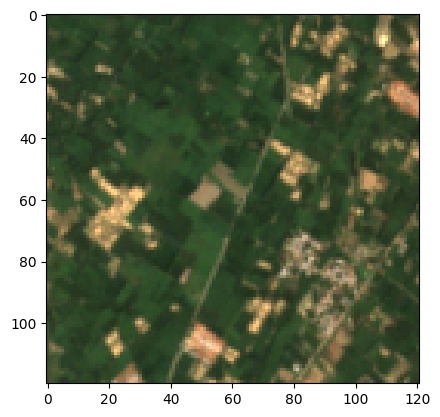

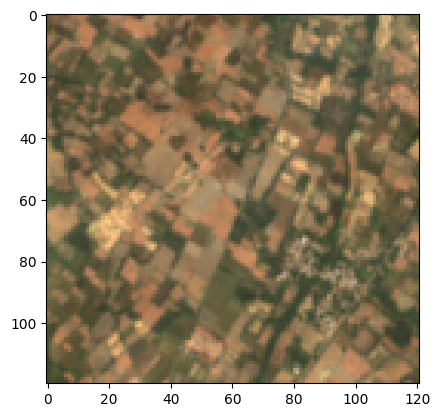

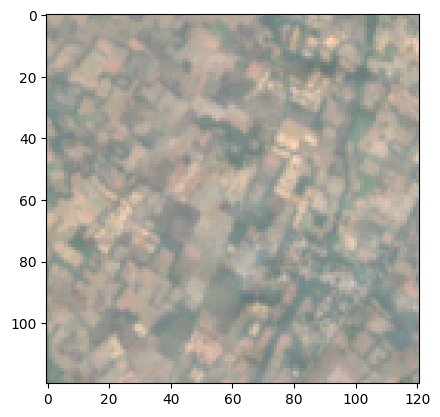

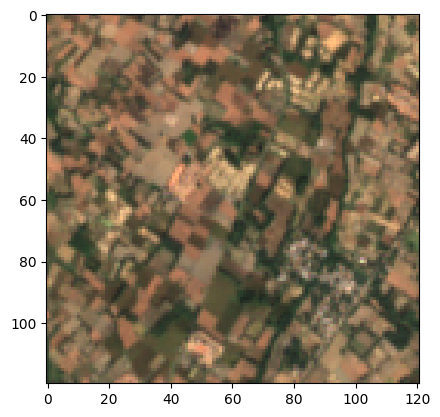

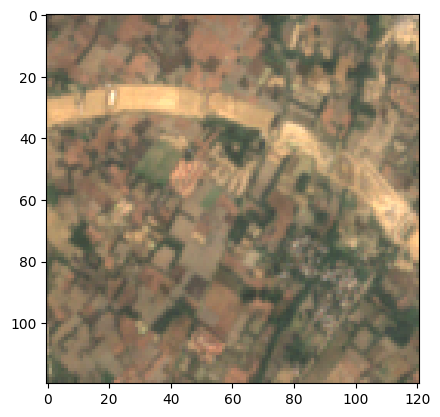

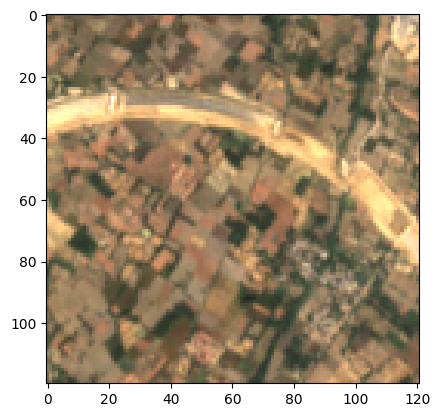

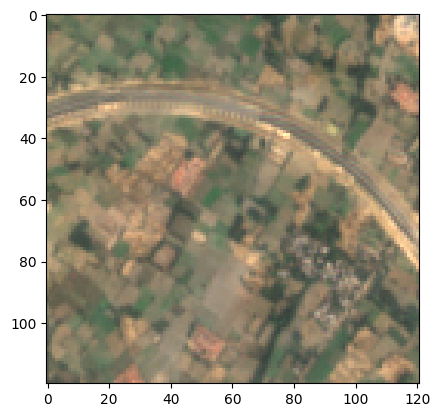

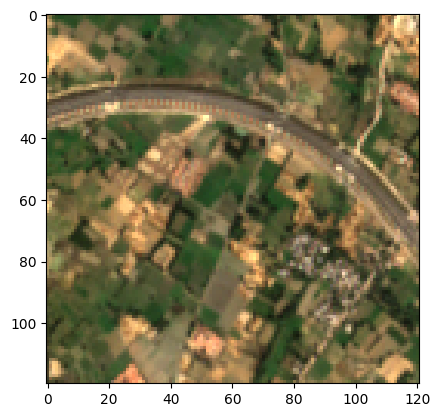

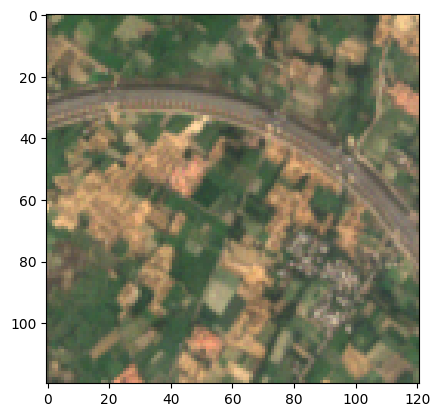

In [21]:
for exp_name in exp_list:
    # Define the path to the directory
    directory_path = f'/home/rishabh.mondal/data_download_experiments/sentinel_data/across_time/{exp_name}/images'
    # plt.imshow((f'{directory_path}/26.61,80.83.png'))
    image = Image.open(f'{directory_path}/26.71,81.18.png')
    plt.imshow(image)
    plt.show()

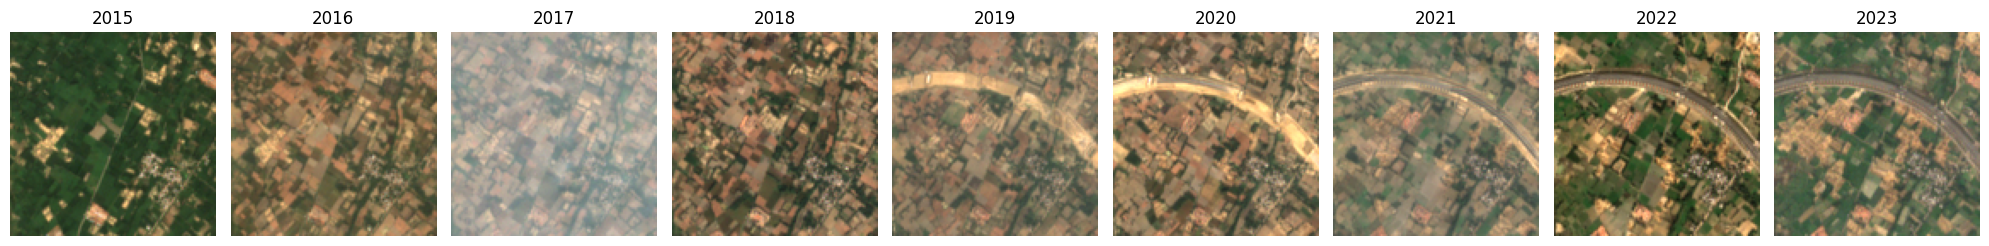

In [22]:
# Number of years
num_years = len(years)

# Create a figure with subplots
fig, axes = plt.subplots(1, num_years, figsize=(20, 10))

# Iterate through each experiment name and corresponding axis
for i, exp_name in enumerate(exp_list):
    # Define the path to the directory
    directory_path = f'/home/rishabh.mondal/data_download_experiments/sentinel_data/across_time/{exp_name}/images'
    # Define the image path
    image_path = f'{directory_path}/26.71,81.18.png'
    
    if os.path.exists(image_path):
        # Open the image
        image = Image.open(image_path)
        # Display the image on the corresponding subplot axis
        axes[i].imshow(image)
        axes[i].set_title(exp_name[-4:])
        axes[i].axis('off')  # Hide the axes
    else:
        print(f'Image not found: {image_path}')

# Adjust layout
plt.tight_layout()
plt.show()

In [4]:
label_dir='/home/rishabh.mondal/data_download_experiments/sentinel_data/across_time/lucknow_sarath_grid_obb_v3/labels'

In [14]:
# Number of years
num_years = len(years)
import matplotlib.image as mpimg
# Create a figure with subplots
# fig, axes = plt.subplots(1, num_years, figsize=(20, 10))

# Iterate through each experiment name and corresponding axis
for i, exp_name in enumerate(exp_list[:1]):
    # Define the path to the directory
    directory_path = f'/home/rishabh.mondal/data_download_experiments/sentinel_data/across_time/{exp_name}/images'
    # Define the image path
    image_path = f'{directory_path}/26.71,81.18.png'

    
    
    if os.path.exists(image_path):
        # Open the image
        image = mpimg.imread(image_path)
        print(image.shape)
        cor = np.loadtxt(label_dir+'/26.71,81.18.txt')
        print(cor)
        rect_x1_sen = cor[1] * image.shape[1]
        rect_y1_sen = cor[2] * image.shape[0]
        width_sen = cor[3] * image.shape[1]  
        height_sen = cor[4] * image.shape[0] 

        # # Adjust rect_x1 and rect_y1 to represent the top-left corner
        # top_left_x_sen = rect_x1_sen - width_sen / 2
        # top_left_y_sen = rect_y1_sen - height_sen / 2
        
        # # Display the image on the corresponding subplot axis
        # axes[i].imshow(image)
        # axes[i].set_title(exp_name[-4:])
        # axes[i].axis('off')  # Hide the axes
        # axes[i].scatter([rect_x1_sen], [rect_y1_sen], c='r') 
        # rect = Rectangle((top_left_x_sen, top_left_y_sen), width_sen, height_sen, linewidth=1, edgecolor='r', facecolor='none')
        # axes[i].add_patch(rect)

            # image = mpimg.imread(image_path)
        
    else:
        print(f'Image not found: {image_path}')

# Adjust layout
# plt.tight_layout()
# plt.show()

(120, 121, 3)
[[0.         0.36639035 0.48854942 0.43221063 0.39556338 0.39682933
  0.37051869 0.33100905 0.46350472]
 [1.         0.45417136 0.92841247 0.4786905  0.8942608  0.4115777
  0.84607725 0.38705855 0.88022892]]


IndexError: index 2 is out of bounds for axis 0 with size 2